# Data Transformation, Model Building, Training and Evaluation

In [1]:
import pandas as pd

In [2]:
df_inliers = pd.read_csv("../data/processed_inliers.csv")
df_outliers = pd.read_csv("../data/processed_outliers.csv")

build two types of models on both **df_inliers** and **df_outliers**:  
- for LogisticRegression model, using **one-hot encoding** for features with medium cardinality  
- for XGBoost model, using **label encoding** for features with medium cardinality
- Then compare the performance, choose one model for inlier and one model for outliet, and save them

### Model 1: df_inliers, Logistic Regression with One-Hot Encoding

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [4]:
# prepare data
df_inliers_lr = df_inliers.copy()

X = df_inliers_lr.drop('fraud_reported', axis=1)
y = df_inliers_lr['fraud_reported']

In [5]:
# separate numerical and categorial columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [6]:
# Preprocessing & Pipeline

X[categorical_cols] = X[categorical_cols].astype(str)

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [7]:
# Train/Test Split & Fit

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['months_as_customer', 'age',
                                                   'policy_deductable',
                                                   'policy_annual_premium',
                                                   'umbrella_limit',
                                                   'capital-gains',
                                                   'capital-loss',
                                                   'incident_hour_of_the_day',
                                                   'number_of_vehicles_involved',
                                                   'bodily_injuries',
                                                   'witnesses',
                                                   'total_claim_amount',
                                                   'injury_claim',
                                                   'property_claim',
                                                   '...
                                                   'insured_sex',
                                                   'insured_education_level',
                                                   'insured_occupation',
                                                   'insured_hobbies',
                                                   'insured_relationship',
                                                   'incident_type',
                                                   'collision_type',
                                                   'incident_severity',
                                                   'authorities_contacted',
                                                   'incident_state',
                                                   'incident_city',
                                                   'incident_location',
                                                   'property_damage',
                                                   'police_report_available',
                                                   'auto_make',
                                                   'auto_model'])])),
                ('logreg', LogisticRegression(max_iter=1000))])

In [8]:
# Evaluation

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
report1 = classification_report(y_test, y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       120
           1       0.70      0.51      0.59        37

    accuracy                           0.83       157
   macro avg       0.78      0.72      0.74       157
weighted avg       0.82      0.83      0.82       157



#### Model 1 (specific for inliers):  
- **Accuracy**: 83%  
- **F1-score** (Fraud class 1): 0.57  
- **Recall** for fraud: 0.49 — room to boost fraud capture rate  

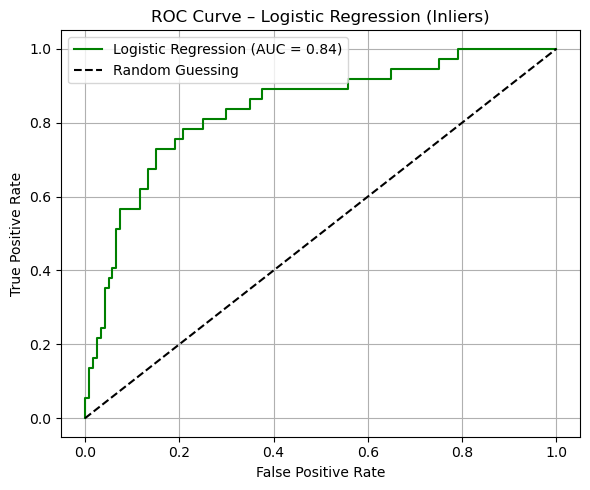

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities (class 1 = fraud)
y_proba_lr = pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression (Inliers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model 2: df_inliers, XGBoost with Label Encoding

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [11]:
df_inliers_xgb = df_inliers.copy()

X = df_inliers_xgb.drop('fraud_reported', axis=1)
y = df_inliers_xgb['fraud_reported']

In [12]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [14]:
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [15]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
report2 = classification_report(y_test, y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       120
           1       0.59      0.62      0.61        37

    accuracy                           0.81       157
   macro avg       0.74      0.74      0.74       157
weighted avg       0.81      0.81      0.81       157



#### Model 2 (specific for inliers):  
- XGBoost is catching more fraud cases (**recall** improved)  
- Overall **F1-score** is higher → great sign of balanced performance.  

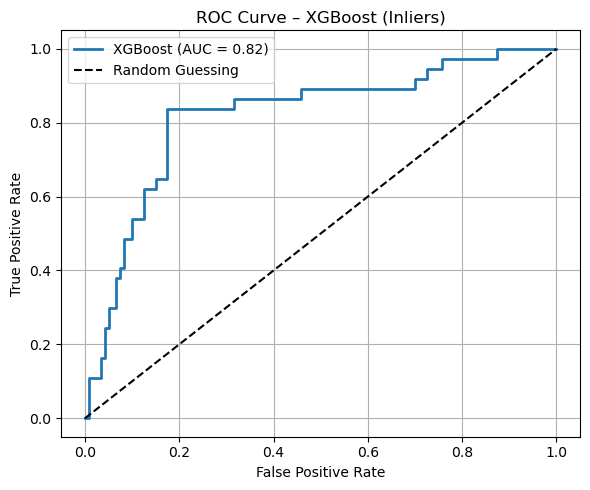

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities (not just class labels)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # probability for class 1 (fraud)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – XGBoost (Inliers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model 3: df_outliers, Logistic Regression with One-Hot Encoding

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [18]:
# prepare data
df_outliers_lr = df_outliers.copy()

X = df_outliers_lr.drop('fraud_reported', axis=1)
y = df_outliers_lr['fraud_reported']

In [19]:
# separate numerical and categorial columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [20]:
# Preprocessing & Pipeline

X[categorical_cols] = X[categorical_cols].astype(str)

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [21]:
# Train/Test Split & Fit

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['months_as_customer', 'age',
                                                   'policy_deductable',
                                                   'policy_annual_premium',
                                                   'umbrella_limit',
                                                   'capital-gains',
                                                   'capital-loss',
                                                   'incident_hour_of_the_day',
                                                   'number_of_vehicles_involved',
                                                   'bodily_injuries',
                                                   'witnesses',
                                                   'total_claim_amount',
                                                   'injury_claim',
                                                   'property_claim',
                                                   '...
                                                   'insured_sex',
                                                   'insured_education_level',
                                                   'insured_occupation',
                                                   'insured_hobbies',
                                                   'insured_relationship',
                                                   'incident_type',
                                                   'collision_type',
                                                   'incident_severity',
                                                   'authorities_contacted',
                                                   'incident_state',
                                                   'incident_city',
                                                   'incident_location',
                                                   'property_damage',
                                                   'police_report_available',
                                                   'auto_make',
                                                   'auto_model'])])),
                ('logreg', LogisticRegression(max_iter=1000))])

In [22]:
# Evaluation

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
report3 = classification_report(y_test, y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.76      0.93      0.84        30
           1       0.67      0.31      0.42        13

    accuracy                           0.74        43
   macro avg       0.71      0.62      0.63        43
weighted avg       0.73      0.74      0.71        43



#### Model 3  (specific for outliers):  
- Outliers likely exaggerate fraudulent patterns (extreme claim sizes, rare categories, etc.)  
- **F1-score** for fraud (0.71) is better than your inlier LR model (0.57)  
- **Recall** for fraud = 0.77, which means this model catches most of the frauds  
- Overall **accuracy** and balance are very strong (despite a small dataset)  

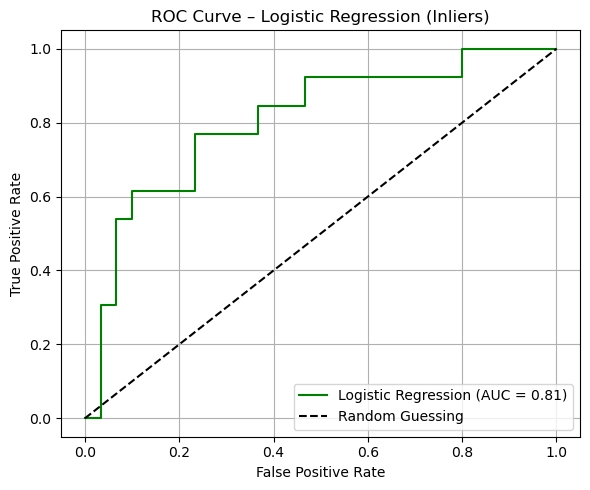

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities (class 1 = fraud)
y_proba_lr = pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression (Inliers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model 4: df_outliers, XGBoost with Label Encoding

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [25]:
df_outliers_xgb = df_outliers.copy()

X = df_outliers_xgb.drop('fraud_reported', axis=1)
y = df_outliers_xgb['fraud_reported']

In [26]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [28]:
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [29]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
report4 = classification_report(y_test, y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.77      0.77      0.77        13

    accuracy                           0.86        43
   macro avg       0.83      0.83      0.83        43
weighted avg       0.86      0.86      0.86        43



#### Model 4 (specific for outliers):  
- Overall **F1-score** is higher than model 2 with logistic regression
- Even higher **accuracy** than model 2

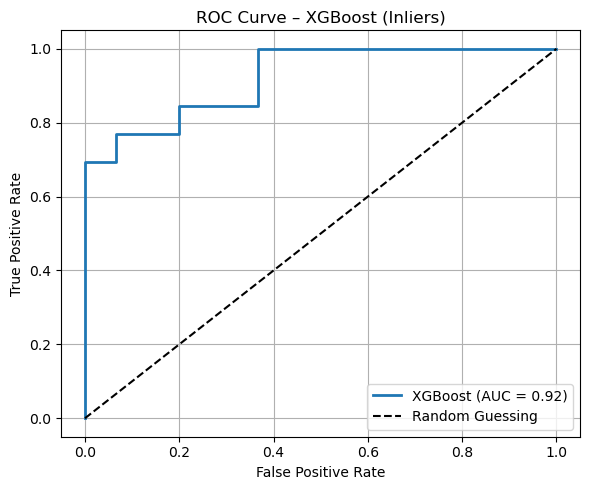

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities (not just class labels)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # probability for class 1 (fraud)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – XGBoost (Inliers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Compare all 4 models for inliers and outliers

In [31]:
model_names = [
    "Model 1: LR Inliers",
    "Model 2: XGB Inliers",
    "Model 3: LR Outliers",
    "Model 4: XGB Outliers"
]

# Extract F1 and Recall for class '1' (fraud)
metrics = {
    "F1 (Fraud)": [report['1']['f1-score'] for report in [report1, report2, report3, report4]],
    "Recall (Fraud)": [report['1']['recall'] for report in [report1, report2, report3, report4]],
    "Precision (Fraud)": [report['1']['precision'] for report in [report1, report2, report3, report4]],
    "Accuracy": [report['accuracy'] for report in [report1, report2, report3, report4]]
}

# Build DataFrame
summary_df = pd.DataFrame(metrics, index=model_names)
summary_df = summary_df.round(2)

summary_df

,F1 (Fraud),Recall (Fraud),Precision (Fraud),Accuracy
Model 1: LR Inliers,0.59,0.51,0.70,0.83
Model 2: XGB Inliers,0.61,0.62,0.59,0.81
Model 3: LR Outliers,0.42,0.31,0.67,0.74
Model 4: XGB Outliers,0.77,0.77,0.77,0.86


for inliers data:  
- model 2 is better because of high recall and overall f1-score  
- model 2 captures more actual fraud cases  
- Precision is a bit lower, but acceptable trade-off

for outliers data:  
- model 4 is obviously better
- all metrics performance better